In [812]:
#Importing the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import joblib as jb

%matplotlib inline

In [813]:
#Defining the alphabet set
alphabets = {
    1: 'A',
    2: 'B',
    3: 'C',
    4: 'D',
    5: 'E',
    6: 'F',
    7: 'G',
    8: 'H',
    9: 'I',
    10: 'J',
    11: 'K',
    12: 'L',
    13: 'M',
    14: 'N',
    15: 'O',
    16: 'P',
    17: 'Q',
    18: 'R',
    19: 'S',
    20: 'T',
    21: 'U',
    22: 'V',
    23: 'W',
    24: 'X',
    25: 'Y',
    26: 'Z'
}

In [814]:
#Function to resize the image to fixed dimensions.
def resize_img(image):
    (h,w,d) = image.shape
    ratio = h/w
    # ratio = 295/1599
    nw = 800
    nh = int(nw*ratio)
    
    return (nw, nh)

In [815]:
#Function to crop the extra whitespace in the image
def crop_img(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    invert = cv2.bitwise_not(image, image)
    bnw = cv2.threshold(invert, 130, 255, cv2.THRESH_BINARY)[1]

    #Detecting the coordinates where pixel value is non-zero i.e. pixel is white
    coords = cv2.findNonZero(bnw)
    x,y,w,h = cv2.boundingRect(coords)

    y1 = y-50
    y2 = y+h+50
    x1 = x-50
    x2 = x+w+50

    if y1 < 0: y1 = 0
    if y2 > image.shape[0]: y2 = image.shape[0]
    if x1 < 0: x1 = 0
    if x2 > image.shape[1]: x2 = image.shape[1]
        
    res = image[y1: y2, x1:x2]
    res = cv2.bitwise_not(res, res)

    return cv2.cvtColor(res, cv2.COLOR_GRAY2BGR)

<Figure size 640x480 with 0 Axes>

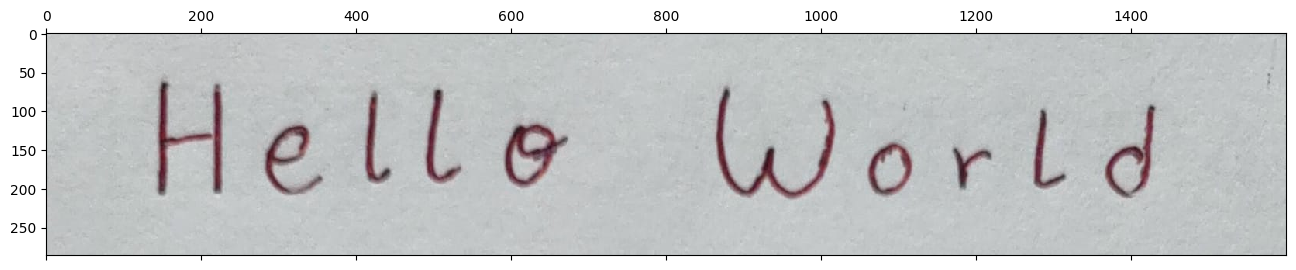

In [816]:
#Reading the input image
img = cv2.imread('sample2.jpeg')

plt.gray()
plt.matshow(img)

IMAGE PREPROCESSING

In [817]:
img = crop_img(img)
dimens = resize_img(img)
img = cv2.resize(img, dimens)

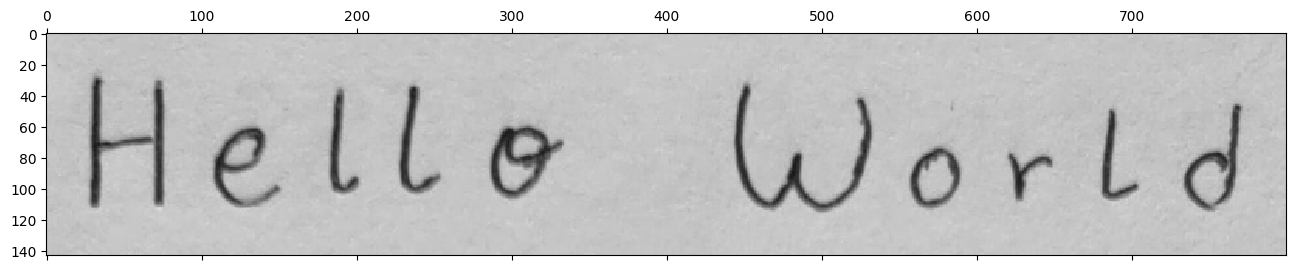

In [818]:
plt.matshow(img)

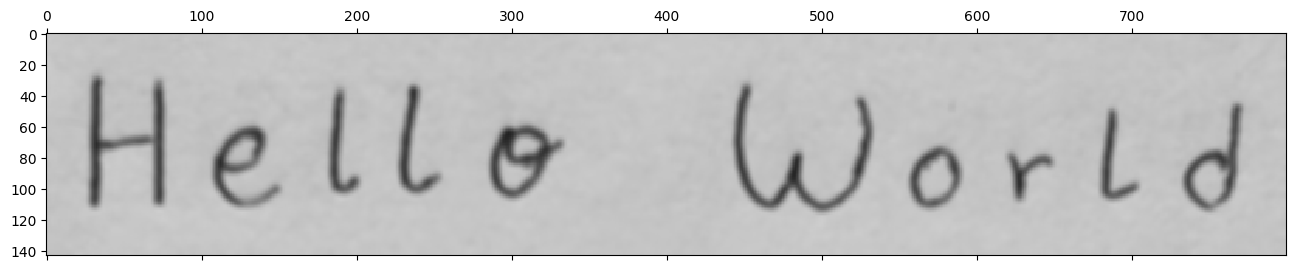

In [819]:
blur = cv2.GaussianBlur(img, (5,5), 10)

plt.matshow(blur)

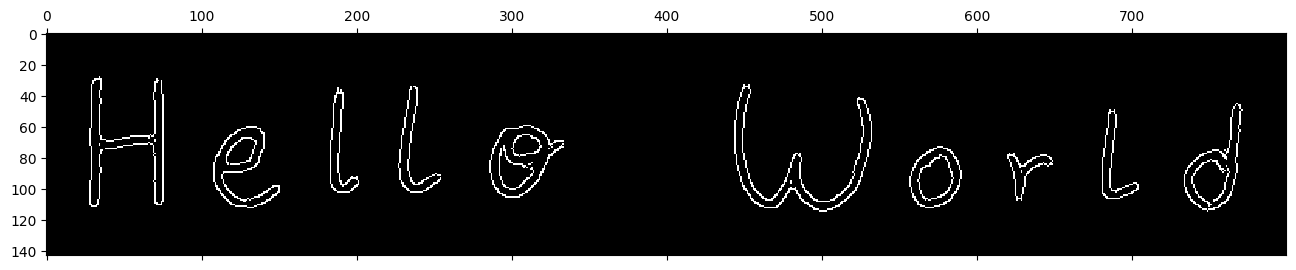

In [820]:
edged = cv2.Canny(blur, 80, 100)

plt.matshow(edged)

DEFINING THE FUNCTIONS

In [821]:
#Function to predict the text written

model = jb.load('model')

def recognize(arr):
    gray = cv2.cvtColor(arr, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (28,28))
    transposed = np.transpose(resized)
    bnw = cv2.threshold(transposed, 180, 255, cv2.THRESH_BINARY)[1]
    bnw_inv = cv2.bitwise_not(bnw, bnw)
    final = bnw_inv.reshape(784)

    prediction = model.predict([final])[0]
    return alphabets[prediction]

In [822]:
#sorting algorithm

def sort_arr(arr, subarr):
    n = len(subarr)
    
    for i in range(1, n):
        for j in range(n-i):
            if subarr[j] > subarr[j+1]:
                subarr[j], subarr[j+1] = subarr[j+1], subarr[j]
                arr[j], arr[j+1] = arr[j+1], arr[j]

In [823]:
#Function to find the break between the words
def search_space(arr, subarr):
    n = len(subarr)

    s = 0

    for i in range(n-1):
        if subarr[i+1] - subarr[i] > 80:
            arr.insert(i+s+1, ' ')
            s += 1

In [824]:
#Function to remove the nested contours

def remove_child_contours(cnts):
    arr = [cv2.boundingRect(c) for c in cnts]

    rects = []

    for i in arr:
        if i[2] > 15 and i[3] > 15:
            rects.append(i)
    
    pos = np.array(rects)[:, 0].tolist()
    
    sort_arr(rects, pos)


    res = []
    prev_x = None
    prev_area = None
    
    for i in rects:
        if prev_x == None:
            prev_x = i[0] + i[2]
            prev_area = i[2]*i[3]
            
            res.append(i)
            continue

        if i[0] > prev_x:
            res.append(i)
            prev_x = i[0] + i[2]
            prev_area = i[2]*i[3]

        elif i[2]*i[3] > prev_area:
            res.pop(-1)
            prev_x = i[0] + i[2]
            prev_area = i[2]*i[3]
            res.append(i)
            

    return res

In [825]:
#Detecting the contours of the characters

contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

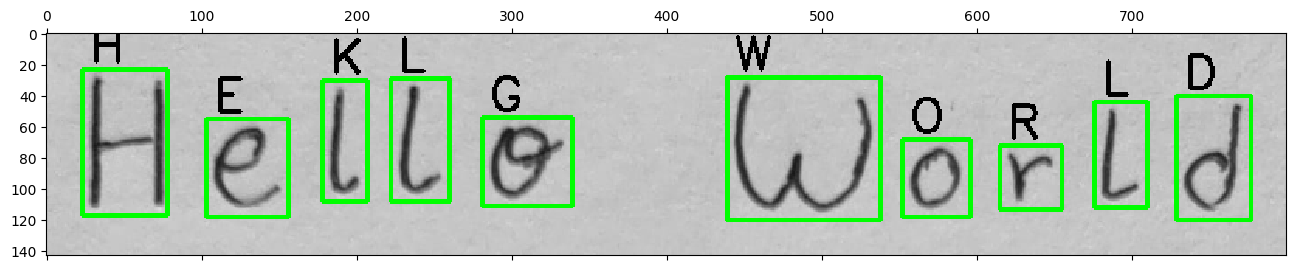

In [826]:
#Drawing the contours on the image

arr = remove_child_contours(contours)
img_copy = img.copy()
text = []
loc = []

for c in arr:
    (x,y,w,h) = c
    
    cv2.rectangle(img_copy, (x-5,y-5), (x+w+5, y+h+5), (0,255,0), 2)
    input = img[y-10:y+h+10, x-10:x+w+10]
    prediction = recognize(input)
    cv2.putText(img_copy, prediction, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2)

    loc.append(x)
    text.append(prediction)


plt.matshow(img_copy)

In [827]:
#Combining the text to give the output

sort_arr(text, loc)
search_space(text, loc)

''.join(text)

'HEKLG W ORLD'